In [16]:
import os
import os
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import StratifiedKFold
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
from torch.utils.data import Dataset, DataLoader

In [17]:
# Define the path to the data
data_path = 'data'

# List the folders in the data path
folders = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]

# Initialize a dictionary to store the count of images in each folder
image_counts = {}

# Iterate through each folder and count the number of image files
for folder in folders:
    folder_path = os.path.join(data_path, folder)
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    image_counts[folder] = len(image_files)

# Display the results
for folder, count in image_counts.items():
    print(f'Folder: {folder}, Number of images: {count}')

Folder: None, Number of images: 906
Folder: Few, Number of images: 5740
Folder: Many, Number of images: 105


In [18]:
# Define input folders
input_folders = {
    'Many': '/home/samo/dev/liver/data/Many',
    'None': '/home/samo/dev/liver/data/None',
    'Few': '/home/samo/dev/liver/data/Few'  # Added Few class
}

# Define output folders
output_folders = {
    'train': {
        'Many': '/home/samo/dev/liver/data_split/train/Many',
        'None': '/home/samo/dev/liver/data_split/train/None',
        'Few': '/home/samo/dev/liver/data_split/train/Few'  # Added Few class
    },
    'val': {
        'Many': '/home/samo/dev/liver/data_split/val/Many',
        'None': '/home/samo/dev/liver/data_split/val/None',
        'Few': '/home/samo/dev/liver/data_split/val/Few'  # Added Few class
    },
    'test': {
        'Many': '/home/samo/dev/liver/data_split/test/Many',
        'None': '/home/samo/dev/liver/data_split/test/None',
        'Few': '/home/samo/dev/liver/data_split/test/Few'  # Added Few class
    }
}


In [19]:
# Function to copy files to the respective folders
def copy_files(file_list, source_folder, destination_folder):
	if not os.path.exists(destination_folder):
		os.makedirs(destination_folder)
	for filename in file_list:
		source_path = os.path.join(source_folder, filename)
		destination_path = os.path.join(destination_folder, filename)
		os.system(f'cp {source_path} {destination_path}')

# Split data into train, validation, and test sets
for class_name, input_folder in input_folders.items():
	filenames = [f for f in os.listdir(input_folder) if f.endswith('.png')]
	train_files, test_files = train_test_split(filenames, test_size=0.2)
	train_files, val_files = train_test_split(train_files, test_size=0.25)  # 0.25 * 0.8 = 0.2

	# Copy files to respective folders
	copy_files(train_files, input_folder, output_folders['train'][class_name])
	copy_files(val_files, input_folder, output_folders['val'][class_name])
	copy_files(test_files, input_folder, output_folders['test'][class_name])

sh: 1: Syntax error: "(" unexpected


In [ ]:
# Display the count of images in each folder
for split in ['train', 'val', 'test']:
    print(f'Split: {split}')
    for class_name in input_folders.keys():
        folder = output_folders[split][class_name]
        image_files = [f for f in os.listdir(folder) if f.endswith('.png')]
        print(f'Class: {class_name}, Number of images: {len(image_files)}')
    print()

Split: train
Class: Many, Number of images: 63
Class: None, Number of images: 543
Class: Few, Number of images: 3444

Split: val
Class: Many, Number of images: 20
Class: None, Number of images: 181
Class: Few, Number of images: 1148

Split: test
Class: Many, Number of images: 21
Class: None, Number of images: 182
Class: Few, Number of images: 1148



In [57]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
import os

# Augmentation pipelines
def get_augmentation_pipeline():
    return A.Compose([
        A.Rotate(limit=15, p=0.8),
        A.HorizontalFlip(p=0.5),
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=20, p=0.5),  # Reduced alpha_affine
        A.ShiftScaleRotate(shift_limit=0.08, scale_limit=0.1, rotate_limit=0, p=0.5),  # Added subtle shifts and scaling
        A.CropAndPad(percent=(-0.15, 0.15), sample_independently=False, p=0.5),  # Added random crop and pad
    ])
    
def apply_augmentations(image, num_augmentations):
    aug_pipeline = get_augmentation_pipeline()
    augmented_images = [aug_pipeline(image=image)['image'] for _ in range(num_augmentations)]
    return augmented_images

# Function to process images in a folder
def process_folder(input_folder, output_folder, num_augmentations):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for filename in os.listdir(input_folder):
        if filename.endswith('.png'):
            image_path = os.path.join(input_folder, filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            augmented_images = apply_augmentations(image, num_augmentations)
            for i, augmented_image in enumerate(augmented_images):
                augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)
                output_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_aug_{i}.png")
                cv2.imwrite(output_path, augmented_image)

In [ ]:
# Define input and output folders
input_folders = {
    'Many': '/home/samo/dev/liver/data_split/train/Many',
    'None': '/home/samo/dev/liver/data_split/train/None'
}
output_folders = {
    'Many': '/home/samo/dev/liver/data_augmented/train/Many',
    'None': '/home/samo/dev/liver/data_augmented/train/None'
}

# Number of augmentations per image for each class
num_augmentations = {
    'Many': 20,  # 10 augmentations for 'Many' class
    'None': 5    # 5 augmentations for 'None' class
}

# Process each folder
for class_name, input_folder in input_folders.items():
    process_folder(input_folder, output_folders[class_name], num_augmentations[class_name])

# Copy the images from the augmented folder to the data_split folder
for class_name in input_folders.keys():
    augmented_folder = output_folders[class_name]
    split_folder = input_folders[class_name]
    for filename in os.listdir(augmented_folder):
        source_path = os.path.join(augmented_folder, filename)
        destination_path = os.path.join(split_folder, filename)
        os.system(f'cp {source_path} {destination_path}')


KeyboardInterrupt: 

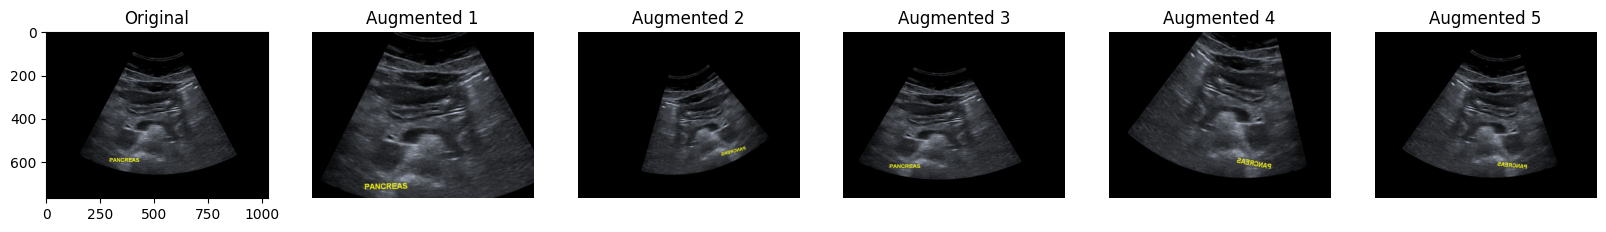

In [59]:
# try example with one image but with different augmentations
image_path = '/home/samo/dev/liver/data/Many/1.2.840.113619.2.116.5609096.1310969575.0.524.4.png'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

aug_pipeline = get_augmentation_pipeline()
augmented_images = [aug_pipeline(image=image)['image'] for _ in range(5)]

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 6, figsize=(20, 5))
axes[0].imshow(image)
axes[0].set_title('Original')
for i, augmented_image in enumerate(augmented_images):
    axes[i + 1].imshow(augmented_image)
    axes[i + 1].set_title(f'Augmented {i + 1}')
    axes[i + 1].axis('off')
plt.show()


In [11]:
# Display the count of images in each folder
for split in ['train', 'val', 'test']:
    print(f'Split: {split}')
    for class_name in input_folders.keys():
        folder = output_folders[split][class_name]
        image_files = [f for f in os.listdir(folder) if f.endswith('.png')]
        print(f'Class: {class_name}, Number of images: {len(image_files)}')
    print()

Split: train
Class: Many, Number of images: 1323
Class: None, Number of images: 3258
Class: Few, Number of images: 3444

Split: val
Class: Many, Number of images: 20
Class: None, Number of images: 181
Class: Few, Number of images: 1148

Split: test
Class: Many, Number of images: 21
Class: None, Number of images: 182
Class: Few, Number of images: 1148



In [53]:
# get with and height of the 20 random images
input_folders = {
    'Many': '/home/samo/dev/liver/data/Many',
}

# Initialize a dictionary to store the width and height of the images
image_sizes = {}

# Iterate through each folder and get the width and height of 20 random images
for class_name, folder in input_folders.items():
    image_files = [f for f in os.listdir(folder) if f.endswith('.png')]
    image_files = np.random.choice(image_files, 20, replace=False)
    sizes = []
    for image_file in image_files:
        image_path = os.path.join(folder, image_file)
        image = cv2.imread(image_path)
        sizes.append(image.shape[:2])
    image_sizes[class_name] = sizes

# Display the results
for class_name, sizes in image_sizes.items():
    print(f'Class: {class_name}')

    # Display the width and height of the images
    for size in sizes:
        print(f'Width: {size[1]}, Height: {size[0]}')

        

Class: Many
Width: 1024, Height: 768
Width: 1024, Height: 768
Width: 1024, Height: 768
Width: 1024, Height: 768
Width: 1024, Height: 768
Width: 1024, Height: 768
Width: 1024, Height: 768
Width: 1024, Height: 768
Width: 1024, Height: 768
Width: 1024, Height: 768
Width: 1024, Height: 768
Width: 1024, Height: 768
Width: 1024, Height: 768
Width: 1024, Height: 768
Width: 1024, Height: 768
Width: 1024, Height: 768
Width: 1024, Height: 768
Width: 1024, Height: 768
Width: 1024, Height: 768
Width: 1024, Height: 768
